In [5]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split , GridSearchCV
import sklearn.ensemble as sk
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report , recall_score ,  precision_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
import seaborn as sns

import os
for dirname, _, filenames in os.walk('C:\project'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

C:\project\FlightDelayPrediction.ipynb
C:\project\Jan_2019_ontime.csv


# **Data Preparation:**

Preparing the data for modeling

In [6]:
# Read data

flight_details_january_2019 = pd.read_csv('C:\project\Jan_2019_ontime.csv')

flight_details_january_2019.head()

,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,OP_CARRIER_AIRLINE_ID,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN,...,DEST,DEP_TIME,DEP_DEL15,DEP_TIME_BLK,ARR_TIME,ARR_DEL15,CANCELLED,DIVERTED,DISTANCE,Unnamed: 21
0,1,2,9E,20363,9E,N8688C,3280,11953,1195302,GNV,...,ATL,601.0,0.0,0600-0659,722.0,0.0,0.0,0.0,300.0,NaN
1,1,2,9E,20363,9E,N348PQ,3281,13487,1348702,MSP,...,CVG,1359.0,0.0,1400-1459,1633.0,0.0,0.0,0.0,596.0,NaN
2,1,2,9E,20363,9E,N8896A,3282,11433,1143302,DTW,...,CVG,1215.0,0.0,1200-1259,1329.0,0.0,0.0,0.0,229.0,NaN
3,1,2,9E,20363,9E,N8886A,3283,15249,1524906,TLH,...,ATL,1521.0,0.0,1500-1559,1625.0,0.0,0.0,0.0,223.0,NaN
4,1,2,9E,20363,9E,N8974C,3284,10397,1039707,ATL,...,FSM,1847.0,0.0,1900-1959,1940.0,0.0,0.0,0.0,579.0,NaN


In [7]:
# check the columns:
flight_details_january_2019.columns

Index(['DAY_OF_MONTH', 'DAY_OF_WEEK', 'OP_UNIQUE_CARRIER',
       'OP_CARRIER_AIRLINE_ID', 'OP_CARRIER', 'TAIL_NUM', 'OP_CARRIER_FL_NUM',
       'ORIGIN_AIRPORT_ID', 'ORIGIN_AIRPORT_SEQ_ID', 'ORIGIN',
       'DEST_AIRPORT_ID', 'DEST_AIRPORT_SEQ_ID', 'DEST', 'DEP_TIME',
       'DEP_DEL15', 'DEP_TIME_BLK', 'ARR_TIME', 'ARR_DEL15', 'CANCELLED',
       'DIVERTED', 'DISTANCE', 'Unnamed: 21'],
      dtype='object')

In [8]:
# check type of columns:
flight_details_january_2019.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 583985 entries, 0 to 583984
Data columns (total 22 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   DAY_OF_MONTH           583985 non-null  int64  
 1   DAY_OF_WEEK            583985 non-null  int64  
 2   OP_UNIQUE_CARRIER      583985 non-null  object 
 3   OP_CARRIER_AIRLINE_ID  583985 non-null  int64  
 4   OP_CARRIER             583985 non-null  object 
 5   TAIL_NUM               581442 non-null  object 
 6   OP_CARRIER_FL_NUM      583985 non-null  int64  
 7   ORIGIN_AIRPORT_ID      583985 non-null  int64  
 8   ORIGIN_AIRPORT_SEQ_ID  583985 non-null  int64  
 9   ORIGIN                 583985 non-null  object 
 10  DEST_AIRPORT_ID        583985 non-null  int64  
 11  DEST_AIRPORT_SEQ_ID    583985 non-null  int64  
 12  DEST                   583985 non-null  object 
 13  DEP_TIME               567633 non-null  float64
 14  DEP_DEL15              567630 non-nu

Understanding for Prediction:
* We have dataset of flights from januray 2019 and we want to predict if some flight will delayed or not. 
* In this dataset, we have 2 columns of delay: 1 column for departure delay [DEP_DEL15], and 1 column for arrivel delay [ARR_DEL15] 
* We want to predict if any flights will be delayed in any time - arrival or departure. So creating a new classifier, named under "delayed" with 2 result:

1.  Delayed - 1 the flight will delay
2.  Delayed - 0 the flight will not delay

In [9]:
flight_details_january_2019['DELAYED'] = (flight_details_january_2019['ARR_DEL15'].astype(bool) | flight_details_january_2019['DEP_DEL15'].astype(bool)).astype(int)


Removing the canceled and diverted flights, because we are looking for flights that succesfuly departed

In [10]:
print("The number of rows before deleted 'Cancelled' column and `DIVERTED` is " + str(flight_details_january_2019.shape[0]) )

flight_details_january_2019.drop(flight_details_january_2019[flight_details_january_2019.CANCELLED == 1].index, inplace=True)

flight_details_january_2019.drop(flight_details_january_2019[flight_details_january_2019.DIVERTED == 1].index, inplace=True)

print("The number of rows after deleted 'Cancelled' column and `DIVERTED` is " + str(flight_details_january_2019.shape[0]) )


The number of rows before deleted 'Cancelled' column and `DIVERTED` is 583985
The number of rows after deleted 'Cancelled' column and `DIVERTED` is 565963


Lets get rid of unuseful columns, that not impact on the results:
* **OP_CARRIER_AIRLINE_ID** - The id of the airline , because we will use the name of airline , for correltions and plots , more clearly to understand ariline name code than the airline id , and after that we will convert the name to numeric value
* **TAIL_NUM** - dosnt give us any information
* **OP_CARRIER_FL_NUM** - dosnt give us any information
* **ORIGIN_AIRPORT_ID** , **'ORIGIN_AIRPORT_ID'** ,**ORIGIN_AIRPORT_SEQ_ID','DEST_AIRPORT_ID','DEST_AIRPORT_SEQ_ID'** - we have instead the origin and destination airport ATA code , more clearly for understading in plots.
* **Unnamed: 21** - Unrelevant column
* **OP_CARRIER** - same as OP_UNIQUE_CARRIER
* **DEP_DEL15** - We convert the DEP and ARR to DELAYED Column
* **ARR_DEL15** - We convert the DEP and ARR to DELAYED Column
* **CANCELED**  - We check only for delayed flight , so Canceled flight are dont relevant
* **DIVERTED**  - We check only for delayed flight , so Canceled flight are dont relevant

In [11]:
flight_details_january_2019.drop(['OP_CARRIER_AIRLINE_ID','TAIL_NUM','OP_CARRIER_FL_NUM','ORIGIN_AIRPORT_ID','ORIGIN_AIRPORT_SEQ_ID','DEST_AIRPORT_ID','DEST_AIRPORT_SEQ_ID','Unnamed: 21','OP_CARRIER','ARR_DEL15','DEP_DEL15','CANCELLED', 'DIVERTED'], axis='columns', inplace=True)


**Checking distribution of the target variable:**


In [12]:
flight_details_january_2019['DELAYED'].value_counts()

0    440724
1    125239
Name: DELAYED, dtype: int64

We can see that there are very highly difference between the rows with value 1 and 0 , so decreasing the rows with value 0.

In [13]:
# Split the data into positive and negative
pos = flight_details_january_2019.loc[flight_details_january_2019.DELAYED == 1]
neg = flight_details_january_2019.loc[flight_details_january_2019.DELAYED == 0]

# Merge the balanced data
data = pd.concat([pos, neg.sample(n = len(pos))], axis = 0)

# Shuffle the order of data
flight_details_january_2019 = data.sample(n = len(data)).reset_index(drop = True)

In [14]:
flight_details_january_2019['DELAYED'].value_counts()

1    125239
0    125239
Name: DELAYED, dtype: int64

Renaming the headings if needed for more readble format:

In [15]:
flight_details_january_2019 = flight_details_january_2019.rename(columns={"OP_UNIQUE_CARRIER": "AIRLINE_CODE"})

Check for some Null/Na values:

In [16]:
flight_details_january_2019.isna().sum()

DAY_OF_MONTH    0
DAY_OF_WEEK     0
AIRLINE_CODE    0
ORIGIN          0
DEST            0
DEP_TIME        0
DEP_TIME_BLK    0
ARR_TIME        0
DISTANCE        0
DELAYED         0
dtype: int64

the data is clean , we dont have any null values.

**Summerize**:

In [17]:
print("The Data types is:")
flight_details_january_2019.info()

The Data types is:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250478 entries, 0 to 250477
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   DAY_OF_MONTH  250478 non-null  int64  
 1   DAY_OF_WEEK   250478 non-null  int64  
 2   AIRLINE_CODE  250478 non-null  object 
 3   ORIGIN        250478 non-null  object 
 4   DEST          250478 non-null  object 
 5   DEP_TIME      250478 non-null  float64
 6   DEP_TIME_BLK  250478 non-null  object 
 7   ARR_TIME      250478 non-null  float64
 8   DISTANCE      250478 non-null  float64
 9   DELAYED       250478 non-null  int32  
dtypes: float64(3), int32(1), int64(2), object(4)
memory usage: 18.2+ MB


In [18]:
print("Our final data include: " + str(flight_details_january_2019.shape[0]) + " Rows and " + str(flight_details_january_2019.shape[1]) + " Columns" )

Our final data include: 250478 Rows and 10 Columns


In [19]:
flight_details_january_2019.head()

,DAY_OF_MONTH,DAY_OF_WEEK,AIRLINE_CODE,ORIGIN,DEST,DEP_TIME,DEP_TIME_BLK,ARR_TIME,DISTANCE,DELAYED
0,23,3,AA,ORD,MIA,838.0,0800-0859,1358.0,1197.0,1
1,14,1,OO,RIC,LGA,1105.0,1000-1059,1233.0,292.0,1
2,21,1,WN,MCI,LGA,630.0,0600-0659,1015.0,1107.0,1
3,6,7,UA,IAH,LGA,1444.0,1400-1459,1920.0,1416.0,0
4,5,6,OH,SDF,CLT,1342.0,1300-1359,1459.0,335.0,0


**Final Data Format:**

After we carefully analyzing each data points, This is the final data:

* DAY_OF_MONTH - Day of Month
* DAY_OF_WEEK - Day of Week
* AIRLINE_CODE - Airline Carrier Code
* ORIGIN - Origin airport location
* DEST - Destination airport location
* DEP_TIME - Actual Departure Time (local time: hhmm)
* DEP_TIME_BLK - Time Block Departure (hhmm-hhmm)
* ARR_TIME - Actual Arrivel Time (local time: hhmm)
* DISTANCE - Distance between airports (miles)
* DELAYED - Classifier - 1 If flight delayed, else - 0

# **Exploratory Data Analysis**


Histograms:

array([[<AxesSubplot:title={'center':'DAY_OF_MONTH'}>,
        <AxesSubplot:title={'center':'DAY_OF_WEEK'}>],
       [<AxesSubplot:title={'center':'DEP_TIME'}>,
        <AxesSubplot:title={'center':'ARR_TIME'}>],
       [<AxesSubplot:title={'center':'DISTANCE'}>,
        <AxesSubplot:title={'center':'DELAYED'}>]], dtype=object)

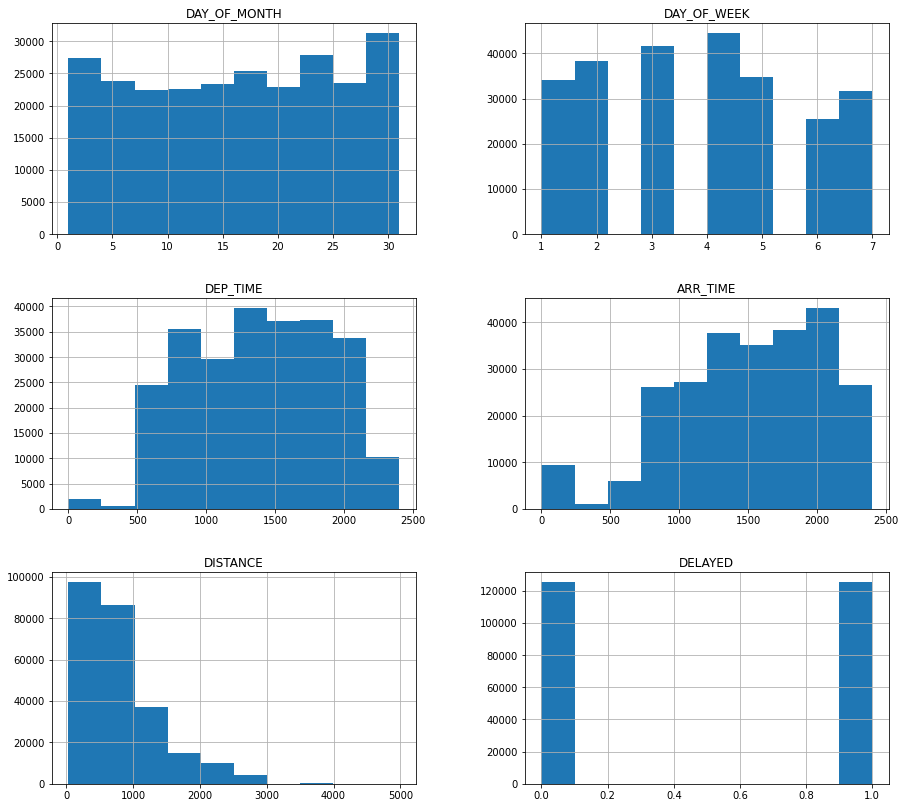

In [20]:

flight_details_january_2019.hist(figsize= (15, 14))

In [21]:
flight_details_january_2019.describe()

,DAY_OF_MONTH,DAY_OF_WEEK,DEP_TIME,ARR_TIME,DISTANCE,DELAYED
count,250478.000000,250478.000000,250478.000000,250478.000000,250478.000000,250478.000000
mean,15.968504,3.840158,1384.994822,1511.828332,811.006719,0.500000
std,9.027552,1.913346,497.642623,549.411762,593.569444,0.500001
min,1.000000,1.000000,1.000000,1.000000,31.000000,0.000000
25%,8.000000,2.000000,1000.000000,1128.000000,370.000000,0.000000
50%,16.000000,4.000000,1415.000000,1553.000000,651.000000,0.500000
75%,24.000000,5.000000,1808.000000,1946.000000,1050.000000,1.000000
max,31.000000,7.000000,2400.000000,2400.000000,4983.000000,1.000000


**Looking for correlations between the features and classifier for better understanding,
and learn a more about the features.** 



First Lets see if there some dfference between airline companies delay, due to result we can understand if there problem with spesific company.

<AxesSubplot:xlabel='AIRLINE_CODE'>

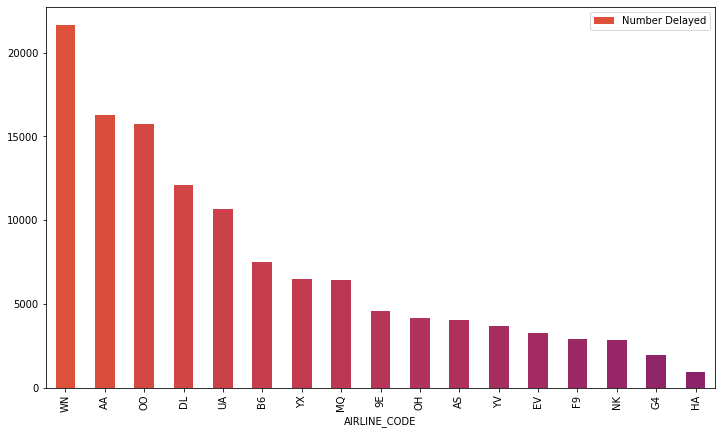

In [22]:
# Count delayes by company
count_delayed=flight_details_january_2019.groupby('AIRLINE_CODE')['DELAYED'].apply(lambda x: (x==1).sum()).reset_index(name='Number Delayed')

color = cm.inferno_r(np.linspace(.4, .8, 30))

count_delayed= count_delayed.sort_values("Number Delayed" , ascending=[False])
count_delayed.plot.bar(x='AIRLINE_CODE', y='Number Delayed', color=color , figsize=(12,7))


Correlation between the day of the month to number of delays:

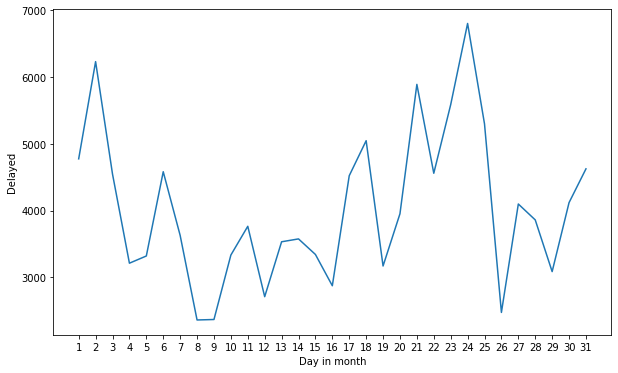

In [23]:
monthly_days_delayed=flight_details_january_2019.groupby('DAY_OF_MONTH')['DELAYED'].apply(lambda x: (x==1).sum()).reset_index(name='Number Delayed')
plt.figure(figsize=(10, 6))
plt.xticks(monthly_days_delayed['DAY_OF_MONTH'])
plt.plot(monthly_days_delayed['DAY_OF_MONTH'],monthly_days_delayed['Number Delayed'])
plt.ylabel('Delayed')
plt.xlabel('Day in month')
plt.show()

Now lets see if there any corellation between the distance and delays:

Avergae Distance with delay: 828.707846597306 mile
Avergae Distance without delay: 793.3055917086531 mile


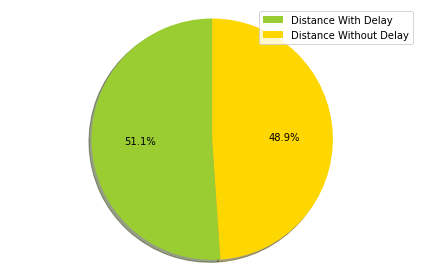

In [24]:
#Calculate the precent of delays with average distance:
avg_distance_delay = flight_details_january_2019[flight_details_january_2019['DELAYED'] == 1]['DISTANCE'].values.mean()
#Calculate the precent of delays without average distance:
avg_distance_without_delay = flight_details_january_2019[flight_details_january_2019['DELAYED'] == 0]['DISTANCE'].values.mean()

print("Avergae Distance with delay: " + str(avg_distance_delay) + " mile")
print("Avergae Distance without delay: "+ str(avg_distance_without_delay) +" mile")

labels = ['Distance With Delay', 'Distance Without Delay']
sizes = [avg_distance_delay,avg_distance_without_delay]
colors = ['yellowgreen', 'gold']
texts = plt.pie(sizes, colors=colors, shadow=True, startangle=90, autopct='%1.1f%%')
plt.legend(labels, loc="best")
plt.axis('equal')
plt.tight_layout()
plt.show()

Let's see in wich day are the higher number of delays:

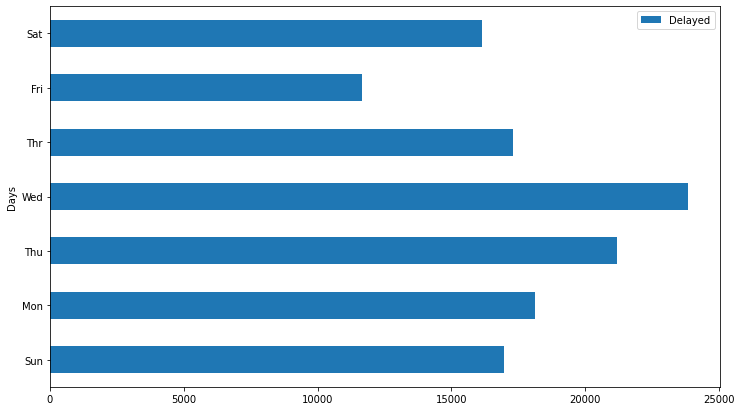

In [25]:
# Create the data for the days adays_values
days_values = flight_details_january_2019.groupby('DAY_OF_WEEK')['DELAYED'].apply(lambda x: (x==1).sum()).reset_index(name='Number Delayed')
days_values.sort_values("DAY_OF_WEEK" )

days_values['DAY_OF_WEEK'] = days_values['DAY_OF_WEEK'].map({1: 'Sun', 2: 'Mon', 3:'Thu',4:'Wed',5:'Thr',6:'Fri',7:'Sat'})

df = pd.DataFrame({'Days':days_values['DAY_OF_WEEK'],'Delayed':days_values['Number Delayed']})
ax = df.plot.barh(x='Days',y='Delayed',figsize=(12,7))

Encoding categorial Variabels before modeling:
* OP_UNIQUE_CARRIER
* ORIGIN
* DEST
* DEST_TIME_BLK

In [26]:
def encode_categories(features):
    lb_make = LabelEncoder()
    for i in range(len(features)):
        flight_details_january_2019[features[i]] = lb_make.fit_transform(flight_details_january_2019[features[i]])


In [27]:
encode_categories(['AIRLINE_CODE','ORIGIN','DEST','DEP_TIME_BLK',])
flight_details_january_2019.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250478 entries, 0 to 250477
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   DAY_OF_MONTH  250478 non-null  int64  
 1   DAY_OF_WEEK   250478 non-null  int64  
 2   AIRLINE_CODE  250478 non-null  int32  
 3   ORIGIN        250478 non-null  int32  
 4   DEST          250478 non-null  int32  
 5   DEP_TIME      250478 non-null  float64
 6   DEP_TIME_BLK  250478 non-null  int32  
 7   ARR_TIME      250478 non-null  float64
 8   DISTANCE      250478 non-null  float64
 9   DELAYED       250478 non-null  int32  
dtypes: float64(3), int32(5), int64(2)
memory usage: 14.3 MB


**Correlations between the features:**

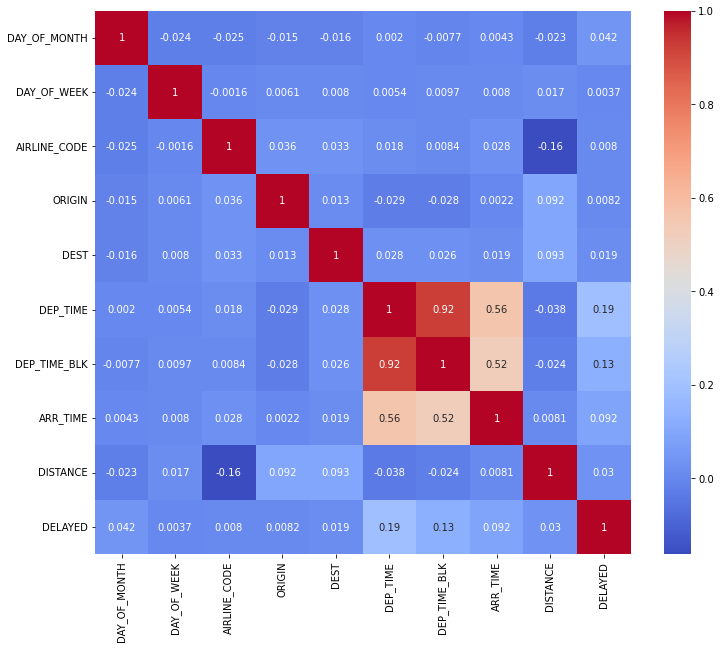

In [28]:
plt.figure(figsize = (12, 10))
sns.heatmap(flight_details_january_2019.corr(), annot = True, cmap = 'coolwarm')
plt.show()

# Modeling

Lets first create Test set and Train set:

In [29]:
# Create test and train:
feature_names = ['DAY_OF_MONTH','DAY_OF_WEEK','AIRLINE_CODE','ORIGIN','DEST','DEP_TIME','DEP_TIME_BLK','ARR_TIME','DISTANCE']
X =  flight_details_january_2019[feature_names].values
y =  flight_details_january_2019['DELAYED'].values

In [30]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)



**Random Forest**

In [31]:
rf = sk.RandomForestClassifier(n_estimators = 350,max_depth=14,min_samples_leaf=15,min_samples_split=5, n_jobs=-1)
rf.fit(X_train,y_train)

RandomForestClassifier(max_depth=14, min_samples_leaf=15, min_samples_split=5,
                       n_estimators=350, n_jobs=-1)

**GradientBoosting**

In [32]:
gb = GradientBoostingClassifier()
gb.fit(X_train,y_train)

GradientBoostingClassifier()

**Decision Tree**

In [33]:
dt = DecisionTreeClassifier(max_depth=15)
dt.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=15)

**AdaBoostClassifier**

In [34]:
ab = AdaBoostClassifier()
ab.fit(X_train, y_train)

AdaBoostClassifier()

# Evaluate

Evaluating of accuarcy of the models

In [35]:
# Acurracy of each model
def get_accuracy(model):
        pred = model[0].predict(X_test)
        check_overfitting(model)
        return accuracy_score(y_test, pred)

In [36]:
def check_overfitting(model):
        pred = model[0].predict(X_test)
        over_fit_check_pred = model[0].predict(X_train)
        print('Checking '+ model[1] + ' Overffiting:')
        print('Train Accuracy ' + str(accuracy_score(y_train, over_fit_check_pred)))
        print('Test Accuracy ' + str(accuracy_score(y_test, pred)))
        print('--------------------------')

In [37]:
# Plot the confusion matrix for each model:
def get_confusion_matrix(model):
    from sklearn.metrics import plot_confusion_matrix
    class_names=['Delay-False','Delay-true']
    disp = plot_confusion_matrix(model[0], X_test, y_test,
                                     display_labels=class_names, values_format='d',
                                     cmap=model[2])
    precision = precision_score(y_test, model[0].predict(X_test), average='binary')
    recall = recall_score(y_test, model[0].predict(X_test), average='binary')
    print('Avg Precision:' +  str(precision))
    print('Avg Recall:' + str(recall))
    
    disp.ax_.set_title(model[1])
    plt.show()

In [38]:
### Save the accuracy
models = [[rf,'Random Forest',plt.cm.Blues],[gb,'Gradient Boosting',plt.cm.Greens],[dt,'Decision Tree',plt.cm.Reds],[ab,'AdaBoost',plt.cm.Oranges]]
accuracy = []
for model in models:
    accuracy.append(get_accuracy(model))

Checking Random Forest Overffiting:
Train Accuracy 0.8245234808993122
Test Accuracy 0.7993984882359204
--------------------------
Checking Gradient Boosting Overffiting:
Train Accuracy 0.7758734757662519
Test Accuracy 0.7746060896412222
--------------------------
Checking Decision Tree Overffiting:
Train Accuracy 0.8280881061288741
Test Accuracy 0.7846268497817523
--------------------------
Checking AdaBoost Overffiting:
Train Accuracy 0.6594898878711488
Test Accuracy 0.6582295326306824
--------------------------


Show the confusion matrix for each model with Recall and Precision

c:\Users\97798\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Avg Precision:0.8337846282024578
Avg Recall:0.7470473752965955


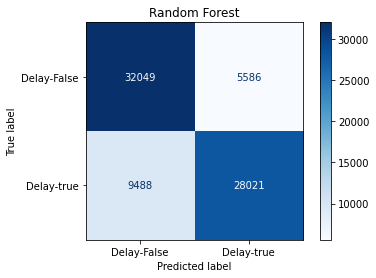

c:\Users\97798\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Avg Precision:0.860330694317943
Avg Recall:0.6547495267802395


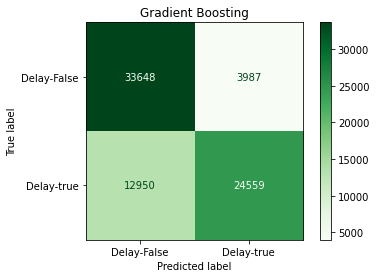

Avg Precision:0.8398406374501992
Avg Recall:0.7024980671305553


c:\Users\97798\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


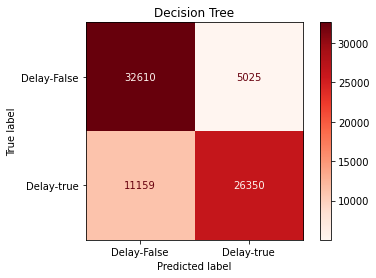

c:\Users\97798\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Avg Precision:0.6556470928855316
Avg Recall:0.6641072809192461


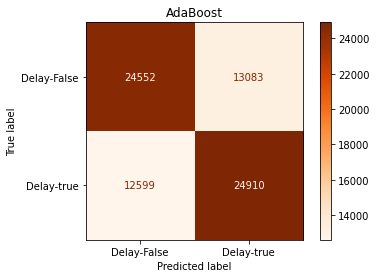

In [39]:
for model in models:
    get_confusion_matrix(model)

Plot accurcay of each model

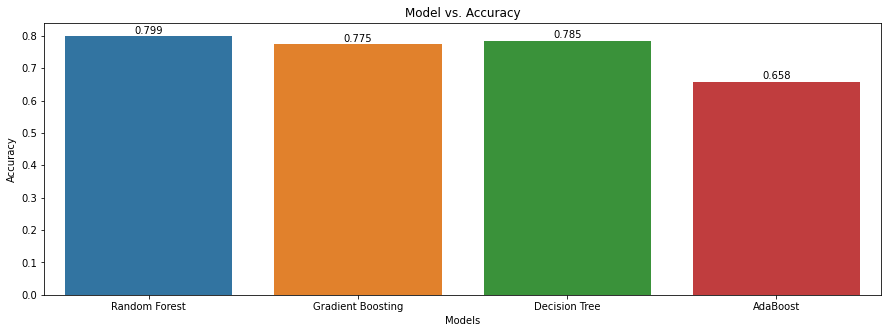

In [40]:
plt.figure(figsize=(15,5))
model_names = ['Random Forest','Gradient Boosting','Decision Tree','AdaBoost']
ax = sns.barplot(x = model_names, y =accuracy)

accuracy_dic = dict(zip(model_names, accuracy))

for p, value in zip(ax.patches, list(accuracy_dic.values())):
    _x = p.get_x() + p.get_width() / 2
    _y = p.get_y() + p.get_height() + 0.008
    ax.text(_x, _y, round(value, 3), ha="center") 

plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Model vs. Accuracy")
plt.show()

In [41]:
print(classification_report(y_test, rf.predict(X_test), target_names=['Delayed','Not Delayed']))

              precision    recall  f1-score   support

     Delayed       0.77      0.85      0.81     37635
 Not Delayed       0.83      0.75      0.79     37509

    accuracy                           0.80     75144
   macro avg       0.80      0.80      0.80     75144
weighted avg       0.80      0.80      0.80     75144



****Feature Importance:****

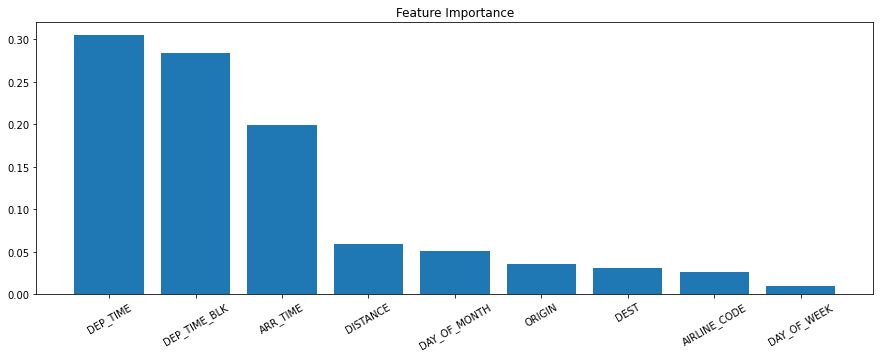

In [42]:
importances = rf.feature_importances_
features = list(flight_details_january_2019.columns)
indices = np.argsort(importances)[::-1]

names = [features[i] for i in indices]

plt.figure(figsize=(15,5))
plt.bar(range(X_train.shape[1]), importances[indices])
plt.xticks(range(X_train.shape[1]), names, rotation=30, fontsize = 10)
plt.title("Feature Importance")
plt.show()

We see that Random Forest give us the best accuracy. Lets try to change the params for Random forset, and maybe we will get better result.

**Hyperparameter tuning for RandomForest**

Test the model again after the optimization and find the good parameters:

In [43]:
# Save the older accur:
rf_old_accur = accuracy[0]

rf = sk.RandomForestClassifier(n_estimators=200, min_samples_split=5, max_features='sqrt', max_depth=45)
rf.fit(X_train,y_train)

pred = rf.predict(X_test)
rf_new_accur = accuracy_score(y_test, pred)

print("The Accuracy of RandomForest Model before tuning: " + str(rf_old_accur))
print("The Accuracy of RandomForest Model after tuning: " + str(rf_new_accur))

print("Increase of : " + str(100-((rf_old_accur * 100 ) / rf_new_accur ))+' %')

The Accuracy of RandomForest Model before tuning: 0.7993984882359204
The Accuracy of RandomForest Model after tuning: 0.8431677845203875
Increase of : 5.1910541517384985 %
